# Angle Recovery with Perfect Distances

In this phase we will try to do angle recovery assuming we know the prefect distances.

The optimization equation looks like this:
\begin{equation}
\label{eq:phase1}
{\{\hat{q_i}\}_{i=1}^N} = \operatorname*{arg\,min}_{\{\hat{q}_i\}_{i=1}^N} \sum_{i,j} \left| d_q(q_i, q_j) - d_q(\hat{q_i}, \hat{q_j}) \right|^2
\end{equation}

We start by random uniform distribution of angle triplets corresponding to the quaternion values $\hat{q_i}$ and $\hat{q_j}$ and we want to see if during the optimization we manage to estimate the true quaternions $q_i$ and $q_j$.


## Content

1. [Data Preparation](Read-Data)
2. [Angle Recovery with Perfect Distances](#Angle-Recovery---Perfect-Distance)
3. [Angle Recovery with Perfect Distances and Variance 0.0](#Angle-Recovery---Variance-0.0)
4. [Angle Recovery with Perfect Distances and Variance 0.2](#Angle-Recovery---Variance-0.2)
5. [Angle Recovery with Perfect Distances and Variance 0.5](#Angle-Recovery---Variance-0.5)

## Read Data

Data used:
- Protein: 5a1a (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5a1a.pdb1-500.jpg)

In [1]:
import os
import h5py
import numpy as np

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot, plot_SO3_space
from IPython.display import Image
from cryoem.angle_recovery import train_angle_recovery

import tensorflow as tf
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays
from cryoem.angle_recovery import geodesic_distance, update_angles, distance_difference, find_best_rotation

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7711797406941956837
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7167169618309652666
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 2181832943531542027
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1312573195772552257
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11322146816
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 17094226386769853759
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_

In [3]:
PROTEIN="5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [4]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

OSError: Unable to open file (unable to open file: name = '../../data/5a1a_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

### True Angles

In [ ]:
angles_true = np.array(data['Angles'])
angles_true.shape

In [ ]:
plot_angles_count(angles_true)

### Predicted Angles

In [ ]:
angle_shift = [0.0, 0.0, 0.0]
angle_coverage = [2.0, 0.4, 2.0]

In [8]:
# from tensorflow.python.framework import ops

# def mod_angles(e, angle_shift, angle_coverage):
#     values = ops.convert_to_tensor(e.values if isinstance(e, ops.IndexedSlices) else e, name="e")

#     v1 = tf.math.mod(values[0], 2*np.pi)
#     v2 = tf.math.mod(values[1], np.pi)
#     v3 = tf.math.mod(values[2], 2*np.pi)
    
#     v1 = tf.clip_by_value(v1, angle_shift[0]*np.pi, angle_shift[0]*np.pi+angle_coverage[0]*np.pi)
#     v2 = tf.clip_by_value(v2, angle_shift[1]*np.pi, angle_shift[1]*np.pi+angle_coverage[1]*np.pi)
#     v3 = tf.clip_by_value(v3, angle_shift[2]*np.pi, angle_shift[2]*np.pi+angle_coverage[2]*np.pi)


#     return tf.stack((v1, v2, v3), axis=-1)

In [9]:
low_ang = [x*np.pi for x in angle_shift]
high_ang = [x*np.pi for x in angle_coverage]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))

# angles_predicted = [tf.Variable(e, constraint=lambda x: mod_angles(x, angle_shift, angle_coverage)) for e in euler]
angles_predicted = [tf.Variable(e) for e in euler]


angles_predicted = np.array(angles_predicted)
angles_predicted.shape

(5000,)

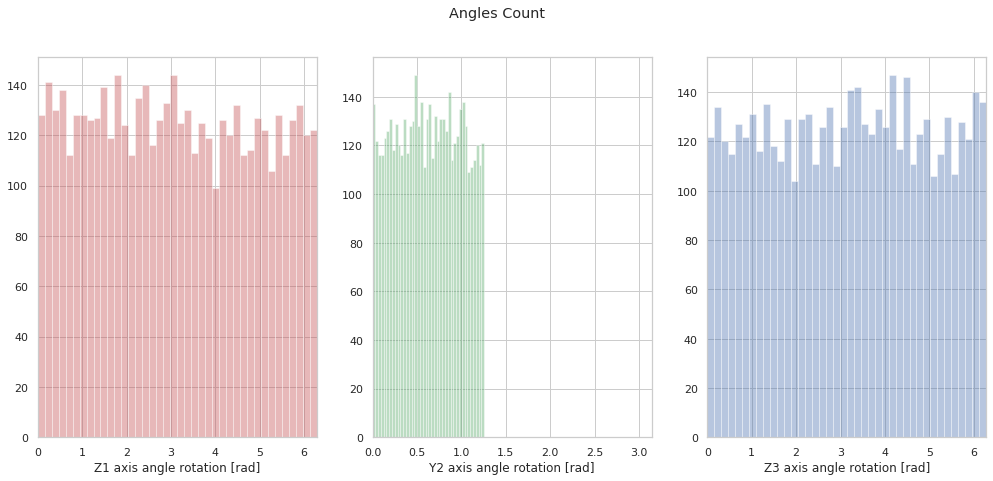

In [10]:
plot_angles_count(angles_predicted)

In [11]:
plot_euclidean_space(angles_predicted)

In [12]:
plot_euclidean_space(angles_true)

---

# Angle Recovery - Perfect Distance

## dP/dQ plot

In [ ]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [ ]:
def d_p(in1, in2):
    return d_q(in1, in2)

In [ ]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=1000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

In [ ]:
plot_dP_dQ(dP_values, dQ_values)

In [ ]:
plot_dP_dQ_density(dP_values, dQ_values)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [16]:
from cryoem.angle_recovery import train_angle_recovery

step 15000/150000 (2425s): loss = 8.45e-02
	avg. distance difference: 1.86
step 30000/150000 (4757s): loss = 7.89e-02
	avg. distance difference: 1.87
step 45000/150000 (7250s): loss = 2.24e-02
	avg. distance difference: 1.86
step 60000/150000 (9689s): loss = 2.13e-03
	avg. distance difference: 1.87
step 75000/150000 (12149s): loss = 9.86e-04
	avg. distance difference: 1.87
step 90000/150000 (14599s): loss = 4.04e-04
	avg. distance difference: 1.87
step 105000/150000 (16990s): loss = 4.89e-04
	avg. distance difference: 1.87
step 120000/150000 (19396s): loss = 4.74e-04
	avg. distance difference: 1.87
step 135000/150000 (21853s): loss = 4.06e-04
	avg. distance difference: 1.87
step 150000/150000 (24372s): loss = 3.55e-04
	avg. distance difference: 1.87


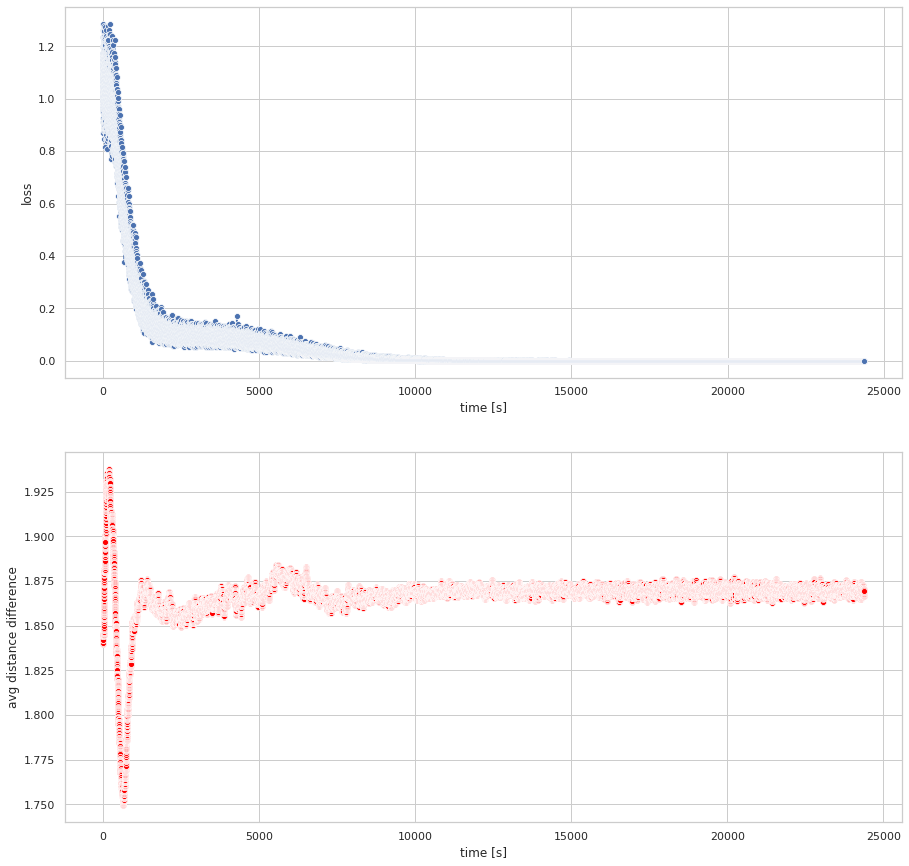

In [17]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [ ]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles.npy")

In [ ]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [9]:
filename = f"figures/{PROTEIN}_before_alignment"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

### Alignment

#### Flip 3rd angle

### Angle Alignment

In [10]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

#### Quaternion Alignment

In [11]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7032069418361836
Geodesic distance:  0.7604611064291664  rad ( 43.57121188224015  degrees)
Quaternion distance:  1.820303758799054


(0.7032069418361836, 0.7604611064291664, 1.820303758799054)

FLIPPING: (1, 1, 1)
step 100/1000 (7s): loss = 1.85e+00
step 200/1000 (13s): loss = 1.79e+00
step 300/1000 (20s): loss = 1.85e+00
step 400/1000 (26s): loss = 1.84e+00
step 500/1000 (33s): loss = 1.81e+00
step 600/1000 (40s): loss = 1.79e+00
step 700/1000 (46s): loss = 1.80e+00
step 800/1000 (53s): loss = 1.89e+00
step 900/1000 (60s): loss = 1.88e+00
step 1000/1000 (67s): loss = 1.82e+00
Rotation: [0.76382324 0.00117915 0.77140278];  Loss: 1.8175205956335607
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 1.58e+00
step 200/1000 (13s): loss = 1.64e+00
step 300/1000 (22s): loss = 1.64e+00
step 400/1000 (30s): loss = 1.63e+00
step 500/1000 (37s): loss = 1.58e+00
step 600/1000 (45s): loss = 1.51e+00
step 700/1000 (52s): loss = 1.54e+00
step 800/1000 (59s): loss = 1.67e+00
step 900/1000 (66s): loss = 1.57e+00
step 1000/1000 (73s): loss = 1.54e+00
Rotation: [-0.03563243  0.04012925 -0.14169526];  Loss: 1.5443685547161932
FLIPPING: (1, -1, 1)
step 100/1000 (8s): loss = 1.78e+00
step 200/1000 (

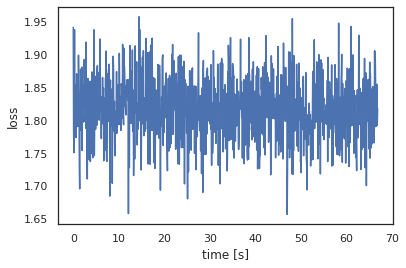

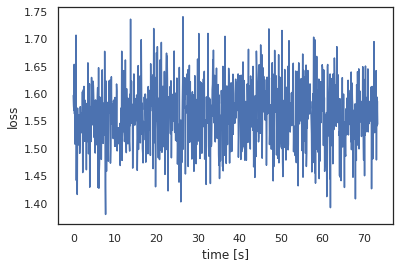

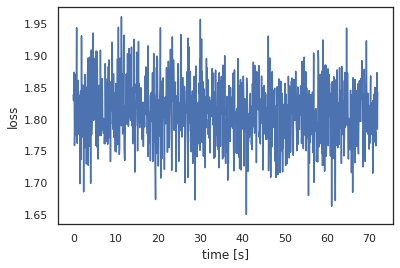

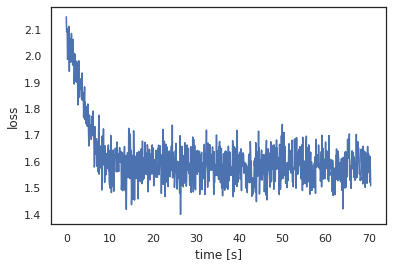

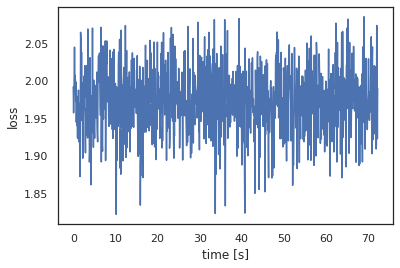

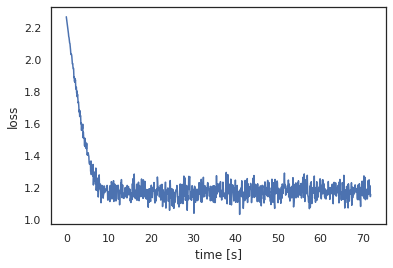

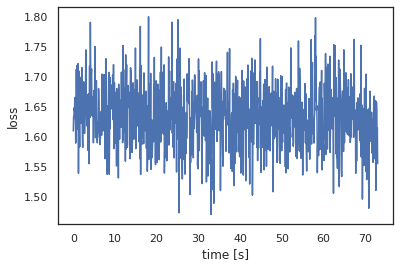

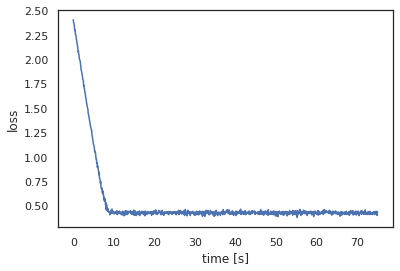

In [12]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [13]:
flips, a_R, loss

((-1, -1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([1.15031648, 0.0031529 , 1.15126079])>],
 0.43213246663519567)

In [14]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [15]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.34588252477702336
Geodesic distance:  0.34892560462977223  rad ( 19.991964509336366  degrees)
Quaternion distance:  0.42454499675778545


(0.34588252477702336, 0.34892560462977223, 0.42454499675778545)

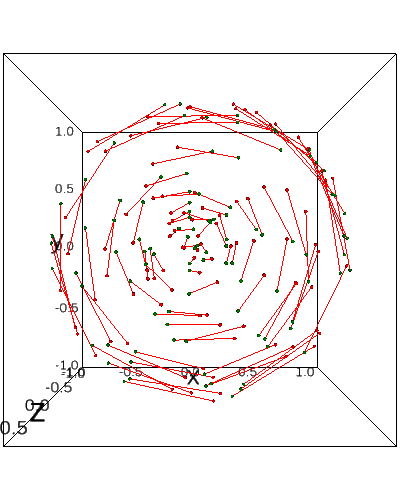

In [16]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [17]:
filename = f"figures/{PROTEIN}_after_alignment"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

In [ ]:
plot_rays(arr, num=100)

In [ ]:
filename = f"figures/{PROTEIN}_rays"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

#### Geodesic Alignment

In [18]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7032069418361836
Geodesic distance:  0.7604611064291664  rad ( 43.57121188224015  degrees)
Quaternion distance:  1.820303758799054


(0.7032069418361836, 0.7604611064291664, 1.820303758799054)

FLIPPING: (1, 1, 1)
step 100/1000 (7s): loss = 7.73e-01
step 200/1000 (15s): loss = 7.46e-01
step 300/1000 (22s): loss = 7.57e-01
step 400/1000 (29s): loss = 7.76e-01
step 500/1000 (36s): loss = 7.24e-01
step 600/1000 (43s): loss = 7.05e-01
step 700/1000 (50s): loss = 6.94e-01
step 800/1000 (57s): loss = 7.37e-01
step 900/1000 (64s): loss = 7.56e-01
step 1000/1000 (71s): loss = 8.01e-01
Rotation: [ 0.         -0.0412851  -0.49207533];  Loss: 0.801277157024894
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 3.43e-02
step 200/1000 (14s): loss = 3.61e-02
step 300/1000 (21s): loss = 3.39e-02
step 400/1000 (29s): loss = 3.32e-02
step 500/1000 (36s): loss = 3.39e-02
step 600/1000 (43s): loss = 3.43e-02
step 700/1000 (50s): loss = 3.36e-02
step 800/1000 (57s): loss = 3.33e-02
step 900/1000 (65s): loss = 3.37e-02
step 1000/1000 (72s): loss = 3.45e-02
Rotation: [ 0.          0.00109568 -0.21280524];  Loss: 0.03452036551905557
FLIPPING: (1, -1, 1)
step 100/1000 (7s): loss = 7.87e-01
step 200/100

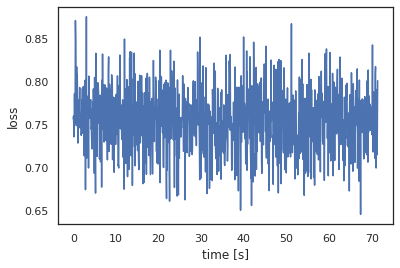

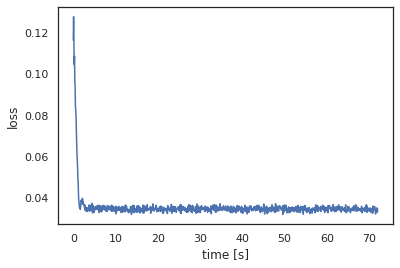

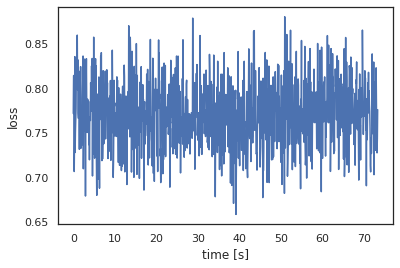

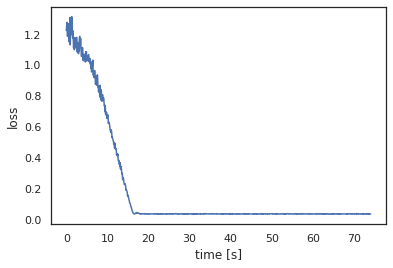

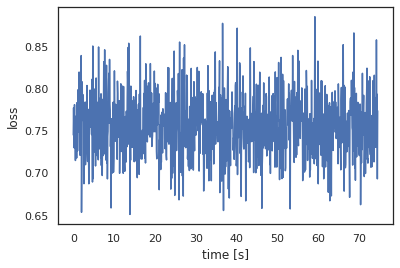

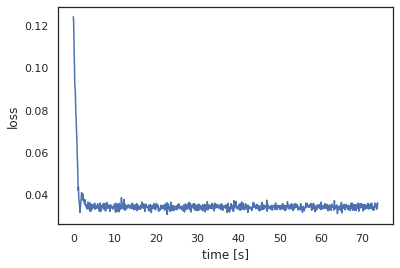

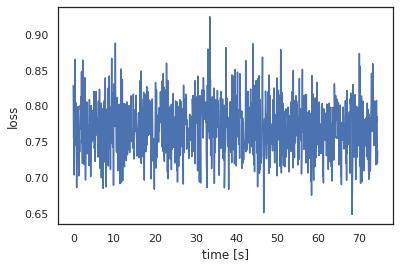

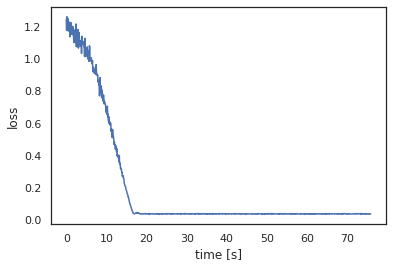

In [19]:
flips, (a_R, loss) = training_angle_alignment_GD_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [20]:
flips, a_R, loss

((1, -1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.00000000e+00, 1.10860774e-03, 2.93574054e+00])>],
 0.03276321573805179)

In [21]:
angles_predicted_new = updateGD_alignment(flips, ap, a_R)

In [22]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.034209162892612256
Geodesic distance:  0.03421200360159162  rad ( 1.9602034150575718  degrees)
Quaternion distance:  1.583063099105853


(0.034209162892612256, 0.03421200360159162, 1.583063099105853)

In [23]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [29]:
filename = f"figures/{PROTEIN}_after_alignmentGD"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

---

# Angle Recovery - Variance 0.0

## dP/dQ plot

In [12]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [13]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.0, dtype=tf.float64)
    return norm_distr  

In [14]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)#.T[0]
dQ_values = d_q(q1_true, q2_true)#.numpy()

<Figure size 432x288 with 0 Axes>

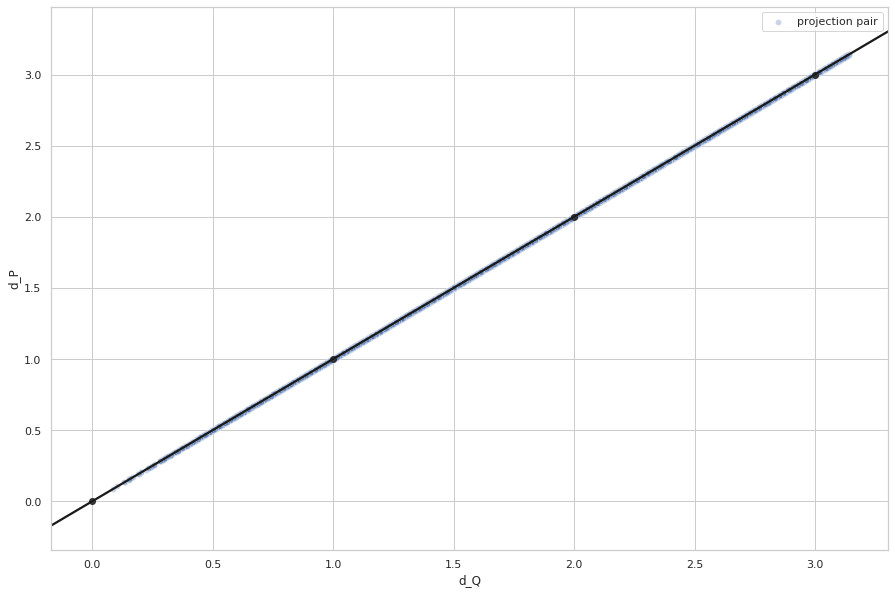

In [15]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

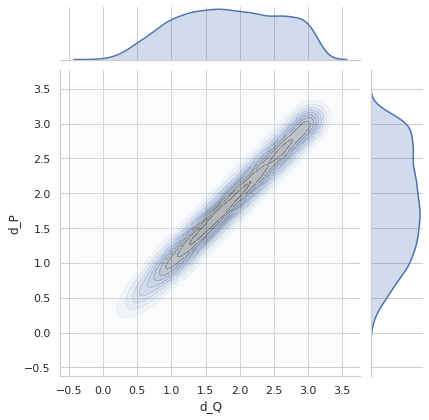

In [16]:
plot_dP_dQ_density(dP_values, dQ_values)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [17]:
from cryoem.angle_recovery import train_angle_recovery

step 15000/150000 (1500s): loss = 6.61e-02
step 30000/150000 (3059s): loss = 9.10e-02
step 45000/150000 (4635s): loss = 3.19e-02
step 60000/150000 (6222s): loss = 2.89e-03
step 75000/150000 (7805s): loss = 5.46e-04
step 90000/150000 (9334s): loss = 3.15e-04
step 105000/150000 (10806s): loss = 3.83e-04
step 120000/150000 (12269s): loss = 4.17e-04
step 135000/150000 (13768s): loss = 4.43e-04
step 150000/150000 (15280s): loss = 4.63e-04


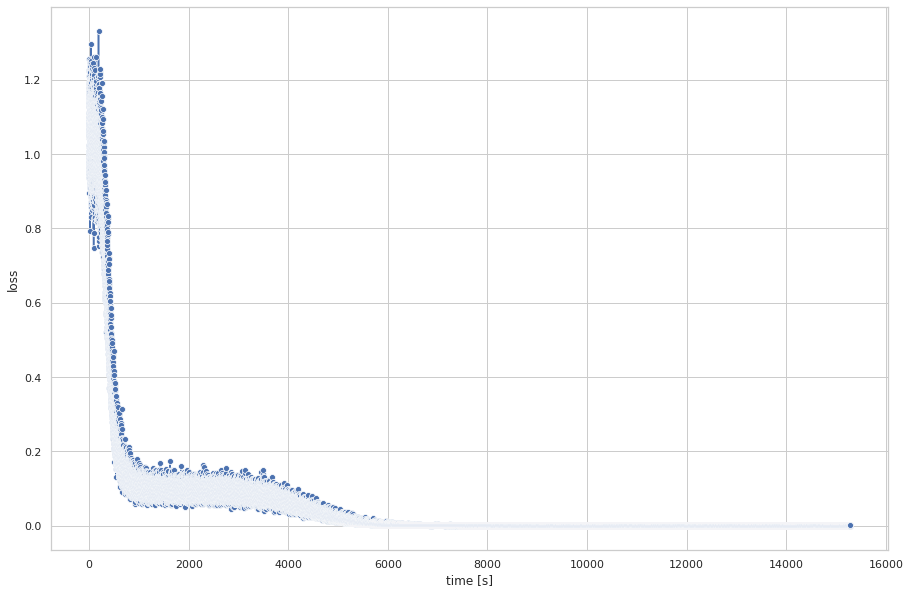

In [18]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [19]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_var0.npy", ang_save)

In [20]:
#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles_var0.npy")

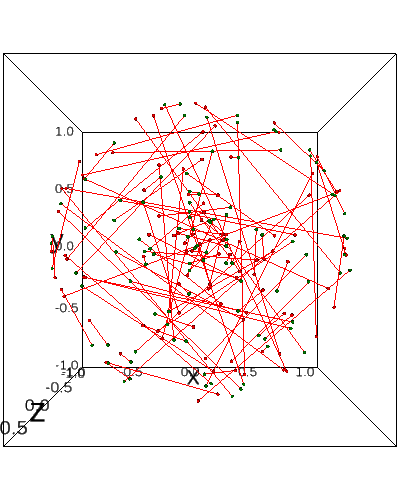

In [21]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [22]:
filename = f"figures/{PROTEIN}_before_alignment_var0"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

### Angle Alignment

In [23]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

#### Quaternion Alignment

In [24]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7045834962517638
Geodesic distance:  0.7627110548478984  rad ( 43.70012443075562  degrees)
Quaternion distance:  2.9827042917375386


(0.7045834962517638, 0.7627110548478984, 2.9827042917375386)

FLIPPING: (1, 1, 1)
step 500/5000 (33s): loss = 8.50e-01
step 1000/5000 (66s): loss = 7.88e-01
step 1500/5000 (98s): loss = 8.54e-01
step 2000/5000 (131s): loss = 8.45e-01
step 2500/5000 (164s): loss = 8.05e-01
step 3000/5000 (197s): loss = 7.59e-01
step 3500/5000 (231s): loss = 8.31e-01
step 4000/5000 (265s): loss = 7.75e-01
step 4500/5000 (299s): loss = 8.31e-01
step 5000/5000 (333s): loss = 7.99e-01
Rotation: [1.65955685 0.02784008 1.47349226];  Loss: 0.7986765517607015
FLIPPING: (1, 1, -1)
step 500/5000 (34s): loss = 1.88e+00
step 1000/5000 (69s): loss = 1.79e+00
step 1500/5000 (103s): loss = 1.94e+00
step 2000/5000 (137s): loss = 1.72e+00
step 2500/5000 (173s): loss = 1.86e+00
step 3000/5000 (208s): loss = 1.73e+00
step 3500/5000 (243s): loss = 1.85e+00
step 4000/5000 (278s): loss = 1.91e+00
step 4500/5000 (313s): loss = 1.73e+00
step 5000/5000 (348s): loss = 1.80e+00
Rotation: [0.56528137 0.01908577 0.73672648];  Loss: 1.8042427620334487
FLIPPING: (1, -1, 1)
step 500/5000 (36s): 

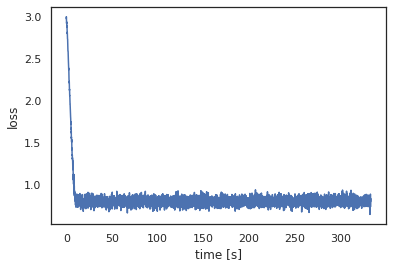

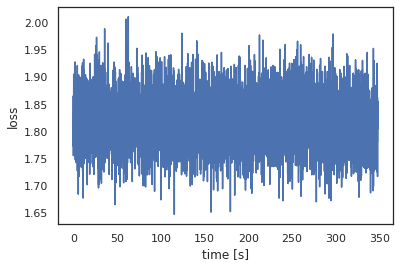

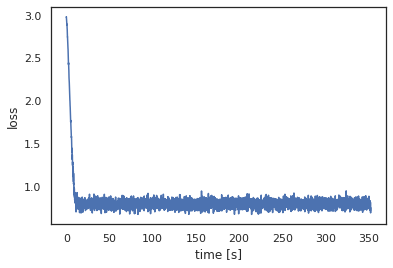

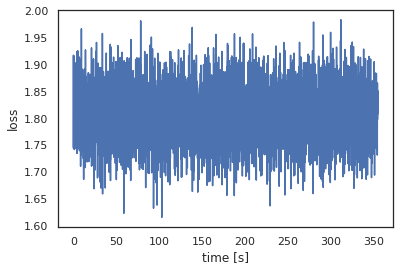

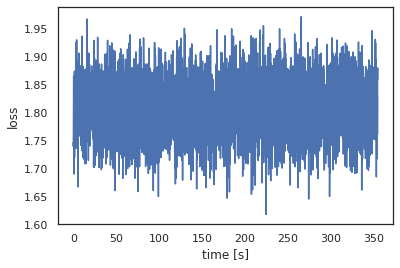

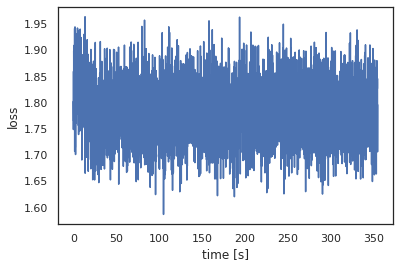

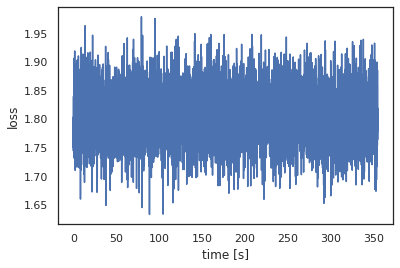

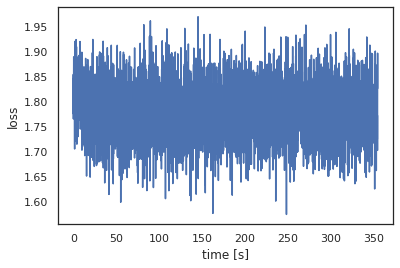

In [25]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=5000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [26]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([1.65955685, 0.02784008, 1.47349226])>],
 0.7986765517607015)

In [27]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [28]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.708708475641252
Geodesic distance:  0.7693563502287543  rad ( 44.08087180969645  degrees)
Quaternion distance:  0.8017133483967951


(0.708708475641252, 0.7693563502287543, 0.8017133483967951)

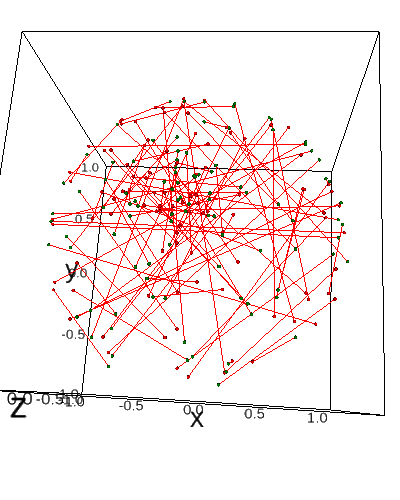

In [29]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [30]:
filename = f"figures/{PROTEIN}_after_alignment_var0"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### Geodesic Alignment

In [31]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7045834962517638
Geodesic distance:  0.7627110548478984  rad ( 43.70012443075562  degrees)
Quaternion distance:  2.9827042917375386


(0.7045834962517638, 0.7627110548478984, 2.9827042917375386)

FLIPPING: (1, 1, 1)
step 500/5000 (34s): loss = 7.96e-01
step 1000/5000 (68s): loss = 7.24e-01
step 1500/5000 (103s): loss = 7.22e-01
step 2000/5000 (138s): loss = 7.19e-01
step 2500/5000 (173s): loss = 7.10e-01
step 3000/5000 (209s): loss = 7.25e-01
step 3500/5000 (245s): loss = 7.19e-01
step 4000/5000 (281s): loss = 7.33e-01
step 4500/5000 (317s): loss = 7.79e-01
step 5000/5000 (353s): loss = 8.18e-01
Rotation: [ 0.         -0.07028314  0.98670425];  Loss: 0.8178537772894925
FLIPPING: (1, 1, -1)
step 500/5000 (36s): loss = 7.82e-01
step 1000/5000 (73s): loss = 7.14e-01
step 1500/5000 (109s): loss = 7.32e-01
step 2000/5000 (146s): loss = 7.16e-01
step 2500/5000 (182s): loss = 7.32e-01
step 3000/5000 (219s): loss = 7.39e-01
step 3500/5000 (255s): loss = 7.64e-01
step 4000/5000 (291s): loss = 7.83e-01
step 4500/5000 (328s): loss = 8.21e-01
step 5000/5000 (364s): loss = 8.38e-01
Rotation: [ 0.         -0.051709   -2.33802745];  Loss: 0.837868850045326
FLIPPING: (1, -1, 1)
step 500/5000 (

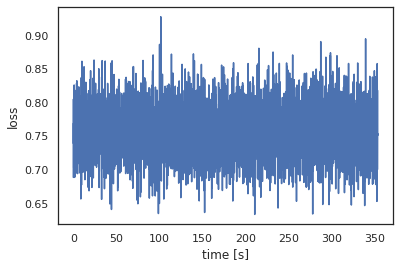

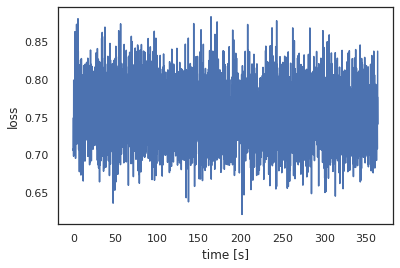

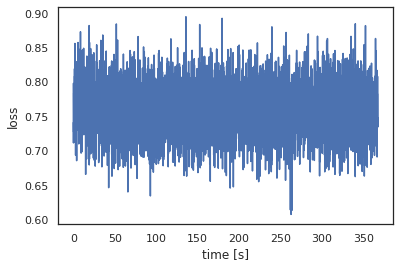

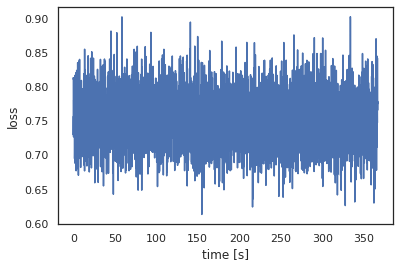

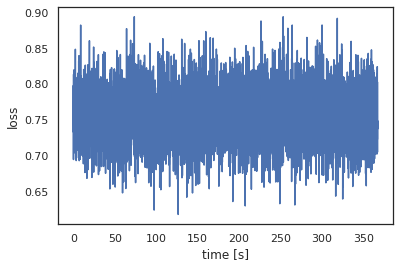

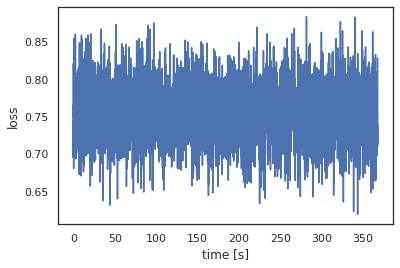

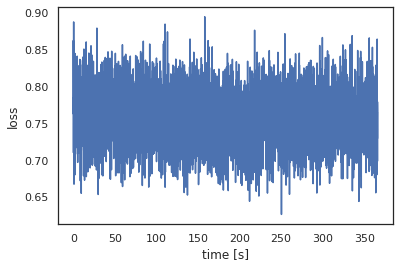

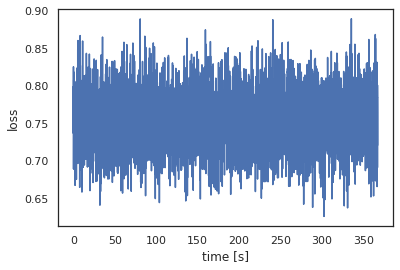

In [32]:
flips, (a_R, loss) = training_angle_alignment_GD_flips(steps=5000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [33]:
flips, a_R, loss

((-1, -1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.        , 0.05916995, 0.88878397])>],
 0.6910974908929102)

In [34]:
angles_predicted_new = updateGD_alignment(flips, ap, a_R)

In [35]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.6980987375870115
Geodesic distance:  0.7537715738569274  rad ( 43.18792989893556  degrees)
Quaternion distance:  1.8184091712635295


(0.6980987375870115, 0.7537715738569274, 1.8184091712635295)

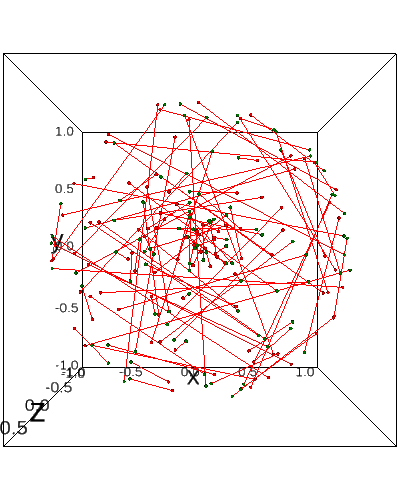

In [36]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [37]:
filename = f"figures/{PROTEIN}_after_alignment_var0GD"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

---

# Angle Recovery - Variance 0.2

## dP/dQ plot

In [7]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.2, dtype=tf.float64)
    return norm_distr  

In [8]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

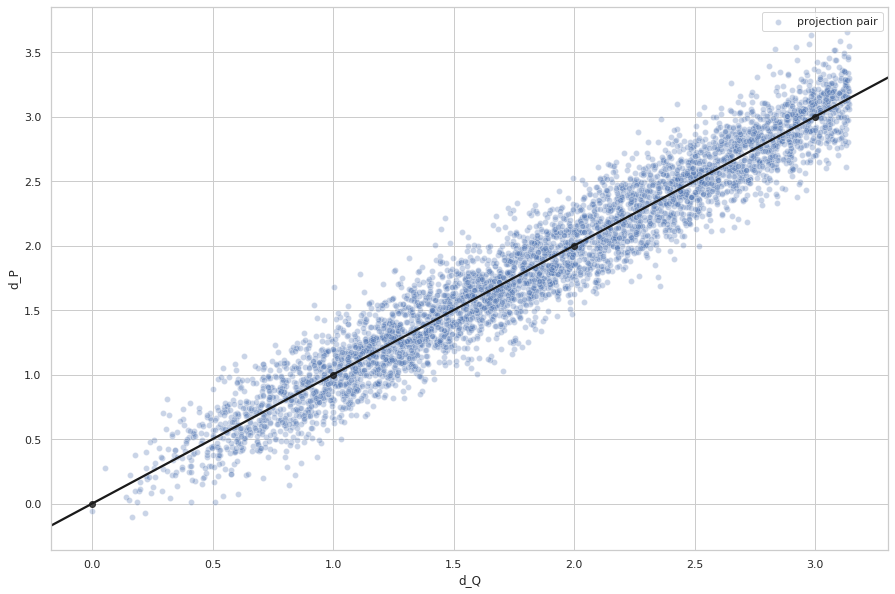

In [9]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

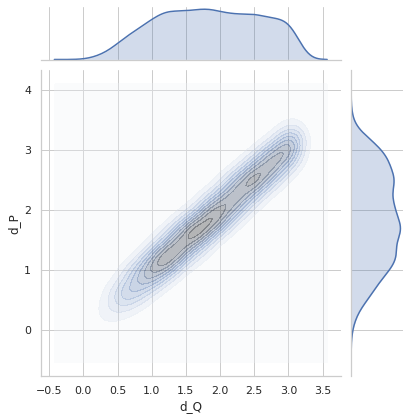

In [10]:
plot_dP_dQ_density(dP_values, dQ_values)

## Angle Recovery

In [11]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1497s): loss = 1.57e-01
step 30000/150000 (2984s): loss = 1.17e-01
step 45000/150000 (4472s): loss = 9.68e-02
step 60000/150000 (5983s): loss = 7.67e-02
step 75000/150000 (7498s): loss = 5.80e-02
step 90000/150000 (9019s): loss = 4.75e-02
step 105000/150000 (10539s): loss = 4.10e-02
step 120000/150000 (12061s): loss = 4.31e-02
step 135000/150000 (13583s): loss = 4.48e-02
step 150000/150000 (15108s): loss = 4.57e-02


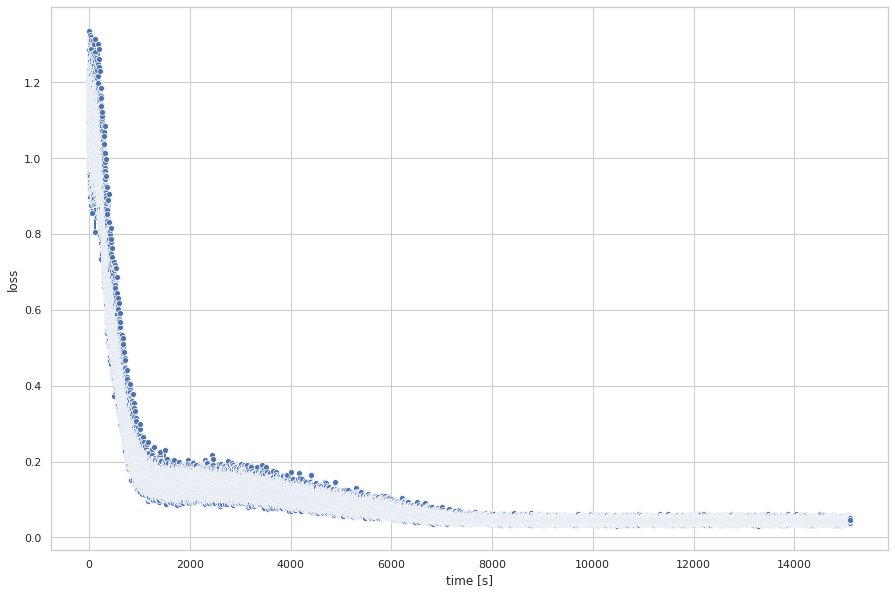

In [16]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [17]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_var0.2.npy", ang_save)

In [11]:
ap = np.load("data/predicted_angles_var0.2.npy")

In [12]:
plot_euclidean_space(ap)

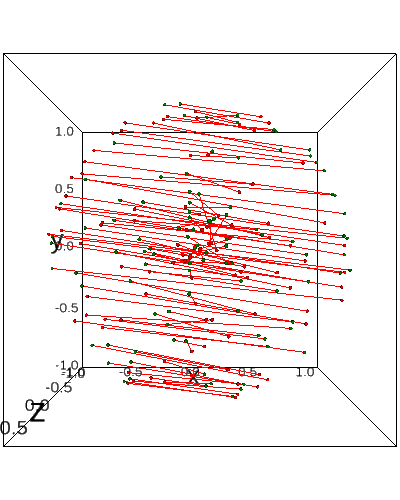

In [12]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [13]:
filename = f"figures/{PROTEIN}_before_alignment_var0.2"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

### Angle Alignment

In [12]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

#### Flip 2nd and 3rd angle

#### Quaternion Alignment

In [16]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7171640657905557
Geodesic distance:  0.777618468080542  rad ( 44.55425629244358  degrees)
Quaternion distance:  1.835719976707717


(0.7171640657905557, 0.777618468080542, 1.835719976707717)

FLIPPING: (1, 1, 1)
step 100/1000 (7s): loss = 1.83e+00
step 200/1000 (14s): loss = 1.76e+00
step 300/1000 (21s): loss = 1.78e+00
step 400/1000 (28s): loss = 1.82e+00
step 500/1000 (36s): loss = 1.84e+00
step 600/1000 (43s): loss = 1.78e+00
step 700/1000 (51s): loss = 1.87e+00
step 800/1000 (58s): loss = 1.82e+00
step 900/1000 (65s): loss = 1.86e+00
step 1000/1000 (72s): loss = 1.78e+00
Rotation: [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([1.41988991, 0.03042958, 1.41505037])>];  Loss: 1.7774665455065515
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 1.62e+00
step 200/1000 (15s): loss = 1.60e+00
step 300/1000 (22s): loss = 1.46e+00
step 400/1000 (29s): loss = 1.63e+00
step 500/1000 (36s): loss = 1.54e+00
step 600/1000 (43s): loss = 1.57e+00
step 700/1000 (50s): loss = 1.54e+00
step 800/1000 (57s): loss = 1.54e+00
step 900/1000 (64s): loss = 1.53e+00
step 1000/1000 (71s): loss = 1.50e+00
Rotation: [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([-

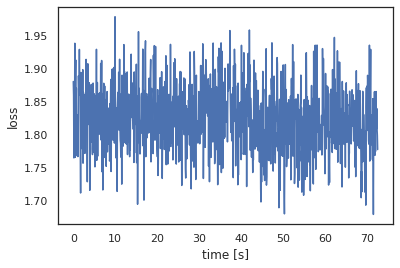

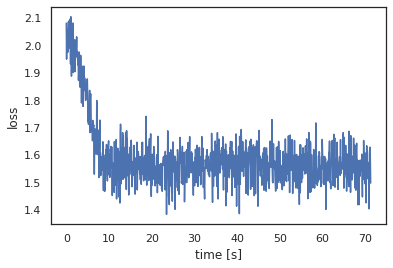

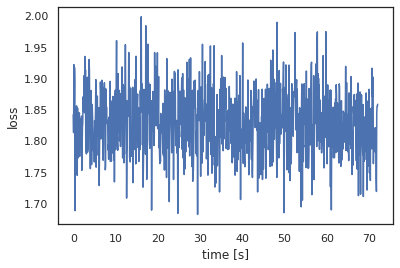

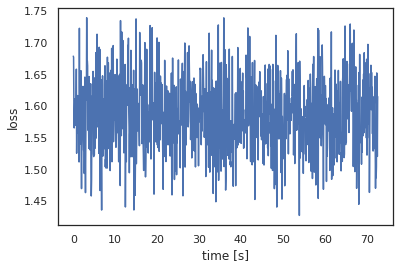

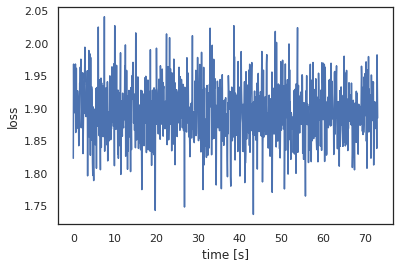

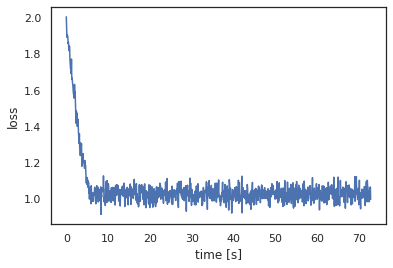

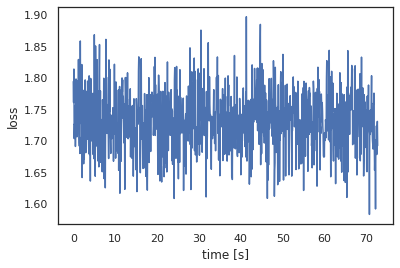

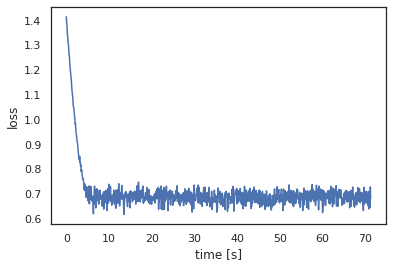

In [19]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [20]:
flips, a_R, loss

((-1, -1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.6723221 , 0.00503317, 0.66916668])>],
 0.6810453277207049)

In [21]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [22]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.5681775972717877
Geodesic distance:  0.5824413158483789  rad ( 33.371429212158255  degrees)
Quaternion distance:  0.6866994489334189


(0.5681775972717877, 0.5824413158483789, 0.6866994489334189)

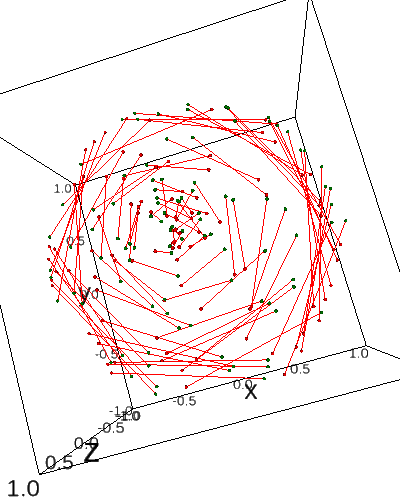

In [23]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [24]:
filename = f"figures/{PROTEIN}_after_alignment_var0.2"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### Geodesic Alignment

In [16]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.7171640657905557
Geodesic distance:  0.777618468080542  rad ( 44.55425629244358  degrees)
Quaternion distance:  1.835719976707717


(0.7171640657905557, 0.777618468080542, 1.835719976707717)

FLIPPING: (1, 1, 1)
step 100/1000 (7s): loss = 8.26e-01
step 200/1000 (14s): loss = 7.71e-01
step 300/1000 (21s): loss = 7.51e-01
step 400/1000 (27s): loss = 7.79e-01
step 500/1000 (34s): loss = 7.87e-01
step 600/1000 (42s): loss = 7.36e-01
step 700/1000 (49s): loss = 8.04e-01
step 800/1000 (56s): loss = 7.18e-01
step 900/1000 (63s): loss = 7.65e-01
step 1000/1000 (70s): loss = 7.20e-01
Rotation: [ 0.         -0.06334259  1.9248379 ];  Loss: 0.7200185228967003
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 9.05e-01
step 200/1000 (14s): loss = 2.01e-01
step 300/1000 (21s): loss = 6.85e-02
step 400/1000 (28s): loss = 7.26e-02
step 500/1000 (35s): loss = 7.28e-02
step 600/1000 (43s): loss = 7.16e-02
step 700/1000 (50s): loss = 6.68e-02
step 800/1000 (57s): loss = 7.01e-02
step 900/1000 (64s): loss = 6.91e-02
step 1000/1000 (71s): loss = 7.11e-02
Rotation: [ 0.00000000e+00 -1.24837731e-03 -2.87253701e+00];  Loss: 0.07105946715836417
FLIPPING: (1, -1, 1)
step 100/1000 (7s): loss = 7.51e-01

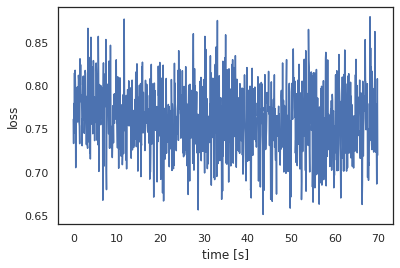

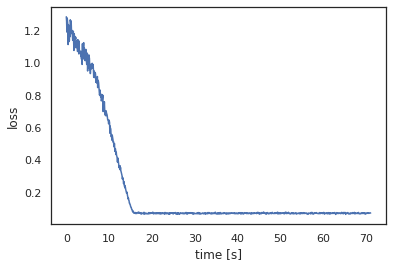

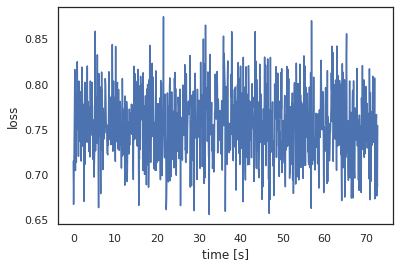

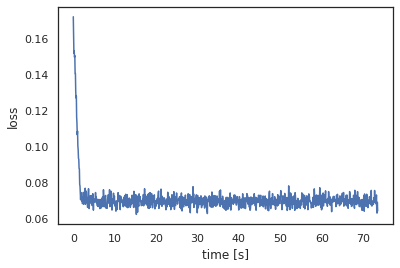

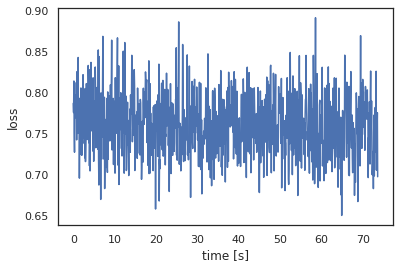

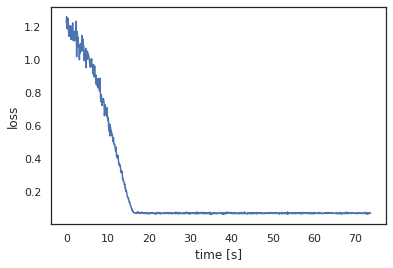

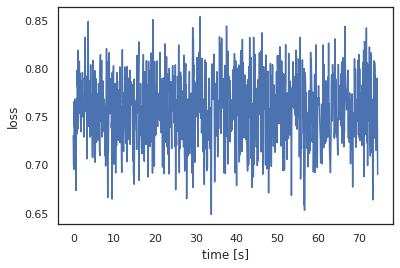

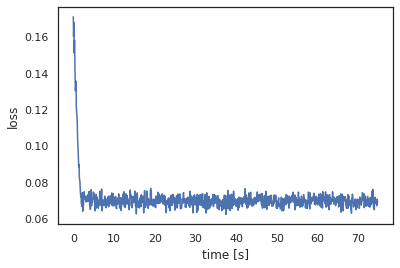

In [17]:
flips, (a_R, loss) = training_angle_alignment_GD_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [18]:
flips, a_R, loss

((1, -1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([ 0.        , -0.00142797,  0.27231616])>],
 0.06444106521169682)

In [19]:
angles_predicted_new = updateGD_alignment(flips, ap, a_R)

In [20]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.06978478434667405
Geodesic distance:  0.06981515712512606  rad ( 4.000113849312421  degrees)
Quaternion distance:  1.5872859139706448


(0.06978478434667405, 0.06981515712512606, 1.5872859139706448)

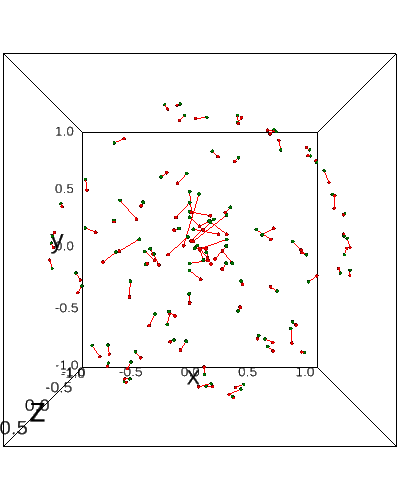

In [21]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [22]:
filename = f"figures/{PROTEIN}_after_alignment_var0.2GD"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

---

---

# Angle Recovery - Variance 0.5

## dP/dQ plot

In [8]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.5, dtype=tf.float64)
    return norm_distr  

In [9]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

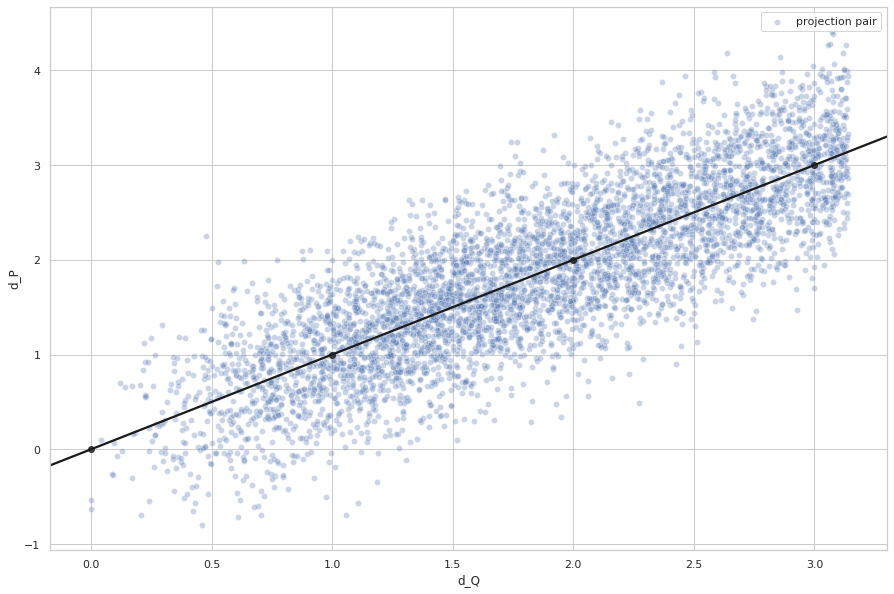

In [10]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

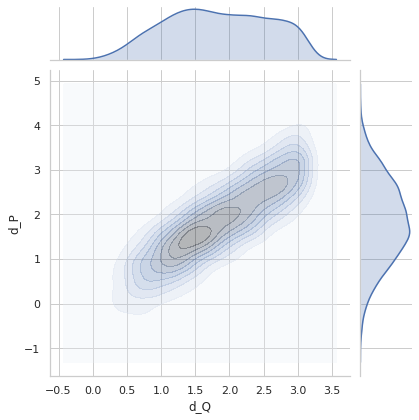

In [11]:
plot_dP_dQ_density(dP_values, dQ_values)

## Angle Recovery

In [17]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1479s): loss = 3.88e-01
step 30000/150000 (3094s): loss = 3.71e-01
step 45000/150000 (4536s): loss = 3.34e-01
step 60000/150000 (5967s): loss = 2.80e-01
step 75000/150000 (7404s): loss = 2.69e-01
step 90000/150000 (8849s): loss = 2.97e-01
step 105000/150000 (10289s): loss = 2.46e-01
step 120000/150000 (11728s): loss = 2.36e-01
step 135000/150000 (13160s): loss = 2.97e-01
step 150000/150000 (14594s): loss = 2.39e-01


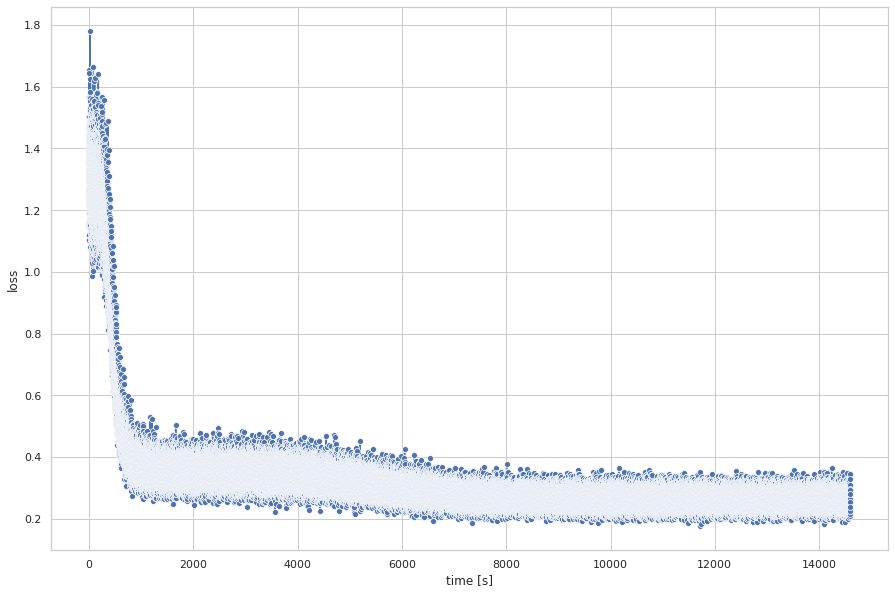

In [18]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [20]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_var0.5.npy", ang_save)

In [12]:
ap = np.load("data/predicted_angles_var0.5.npy")

In [13]:
plot_euclidean_space(ap)

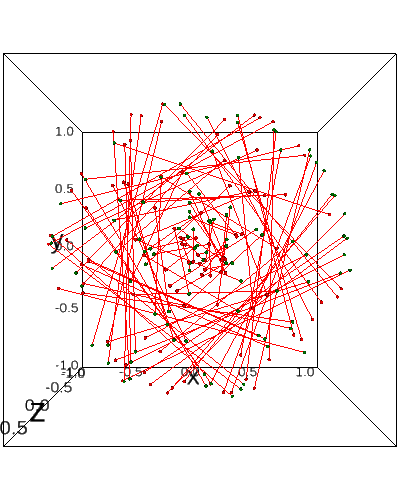

In [14]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [15]:
filename = f"figures/{PROTEIN}_before_alignment_var0.5"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

### Angle Alignment

In [16]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

#### Flip 2nd and 3rd angle

#### Quaternion Alignment

In [26]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.9324589901125475
Geodesic distance:  1.0115875841705928  rad ( 57.95969918080989  degrees)
Quaternion distance:  2.8346353468529544


(0.9324589901125475, 1.0115875841705928, 2.8346353468529544)

FLIPPING: (1, 1, 1)
step 100/1000 (7s): loss = 1.10e+00
step 200/1000 (13s): loss = 6.23e-01
step 300/1000 (20s): loss = 5.99e-01
step 400/1000 (26s): loss = 6.31e-01
step 500/1000 (33s): loss = 5.99e-01
step 600/1000 (39s): loss = 5.97e-01
step 700/1000 (46s): loss = 6.05e-01
step 800/1000 (52s): loss = 5.95e-01
step 900/1000 (59s): loss = 6.00e-01
step 1000/1000 (65s): loss = 6.08e-01
Rotation: [-1.43934947 -0.03795139 -1.47715881];  Loss: 0.6081999051700688
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 1.66e+00
step 200/1000 (13s): loss = 1.69e+00
step 300/1000 (20s): loss = 1.71e+00
step 400/1000 (26s): loss = 1.74e+00
step 500/1000 (33s): loss = 1.71e+00
step 600/1000 (39s): loss = 1.76e+00
step 700/1000 (46s): loss = 1.76e+00
step 800/1000 (52s): loss = 1.70e+00
step 900/1000 (59s): loss = 1.73e+00
step 1000/1000 (65s): loss = 1.71e+00
Rotation: [-0.89660289  0.05199161 -0.7643695 ];  Loss: 1.7119067920224431
FLIPPING: (1, -1, 1)
step 100/1000 (6s): loss = 1.53e+00
step 200/100

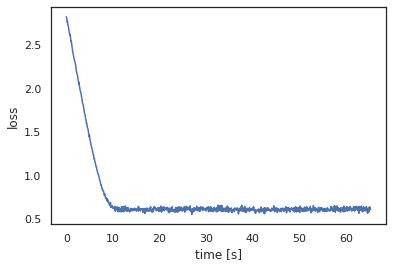

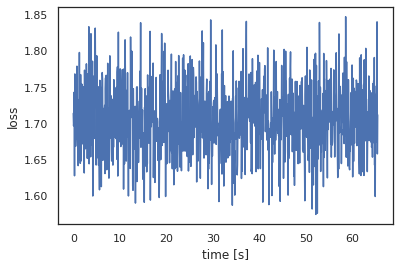

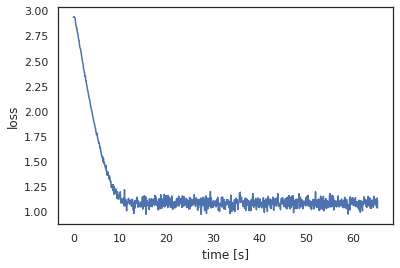

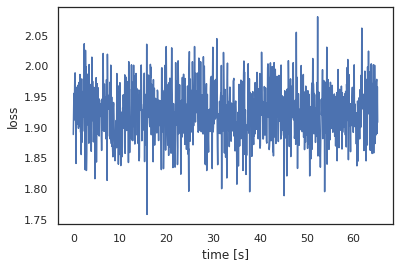

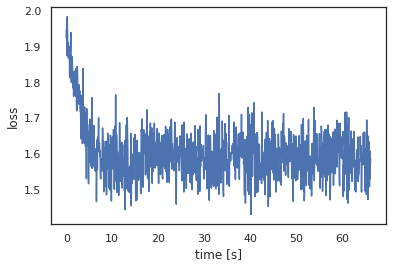

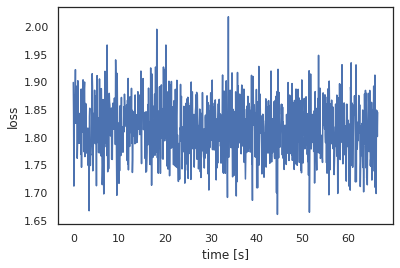

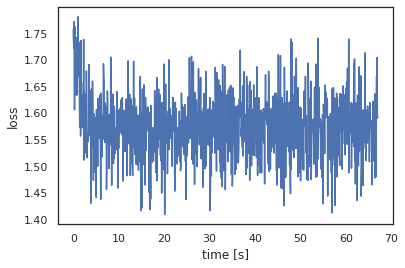

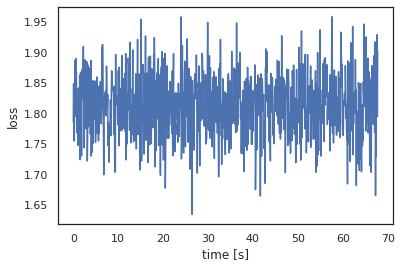

In [27]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [28]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([-1.43934947, -0.03795139, -1.47715881])>],
 0.6081999051700688)

In [29]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [30]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.49183101320633604
Geodesic distance:  0.5007041511794403  rad ( 28.688234647262252  degrees)
Quaternion distance:  0.6052543139518002


(0.49183101320633604, 0.5007041511794403, 0.6052543139518002)

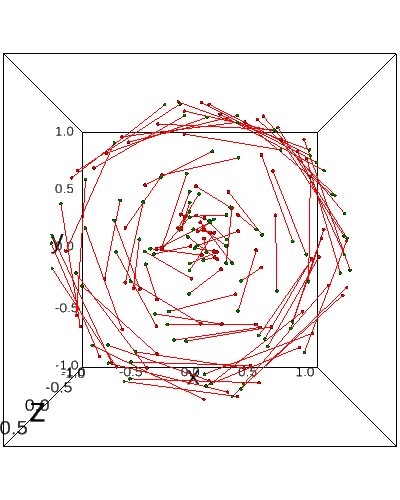

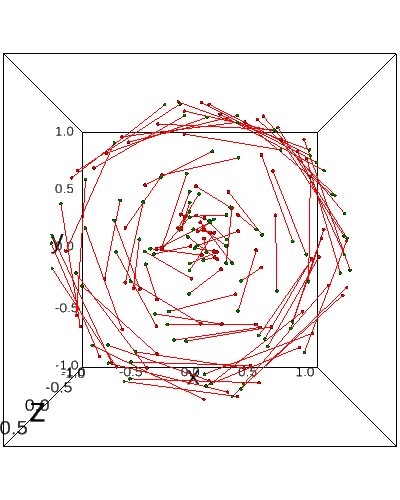

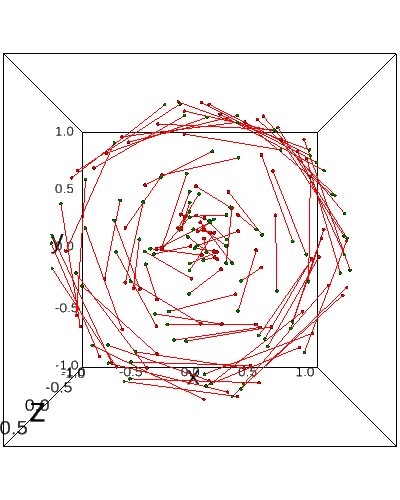

In [31]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [34]:
filename = f"figures/{PROTEIN}_after_alignment_var0.5"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### Geodesic Alignment

In [17]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.9324589901125475
Geodesic distance:  1.0115875841705928  rad ( 57.95969918080989  degrees)
Quaternion distance:  2.8346353468529544


(0.9324589901125475, 1.0115875841705928, 2.8346353468529544)

FLIPPING: (1, 1, 1)
step 100/1000 (7s): loss = 5.69e-01
step 200/1000 (14s): loss = 9.98e-02
step 300/1000 (21s): loss = 1.03e-01
step 400/1000 (27s): loss = 9.76e-02
step 500/1000 (34s): loss = 9.70e-02
step 600/1000 (41s): loss = 1.04e-01
step 700/1000 (48s): loss = 9.73e-02
step 800/1000 (54s): loss = 9.96e-02
step 900/1000 (61s): loss = 1.02e-01
step 1000/1000 (68s): loss = 9.93e-02
Rotation: [ 0.00000000e+00  8.66233473e-04 -2.01629764e+00];  Loss: 0.09926133581335697
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 7.87e-01
step 200/1000 (14s): loss = 7.45e-01
step 300/1000 (20s): loss = 7.83e-01
step 400/1000 (27s): loss = 7.73e-01
step 500/1000 (34s): loss = 6.77e-01
step 600/1000 (41s): loss = 8.54e-01
step 700/1000 (47s): loss = 7.55e-01
step 800/1000 (54s): loss = 7.53e-01
step 900/1000 (61s): loss = 8.35e-01
step 1000/1000 (67s): loss = 7.96e-01
Rotation: [ 0.         -0.06987441  1.15007914];  Loss: 0.7964397255278362
FLIPPING: (1, -1, 1)
step 100/1000 (7s): loss = 1.34e-01

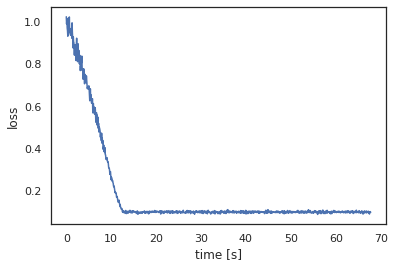

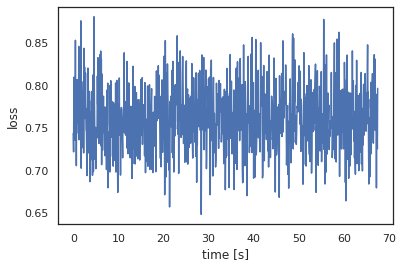

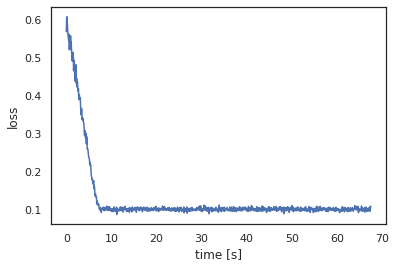

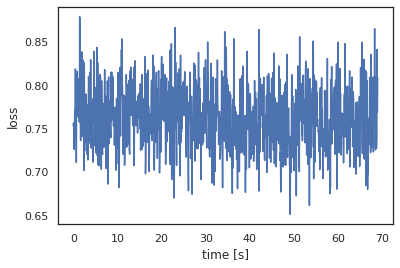

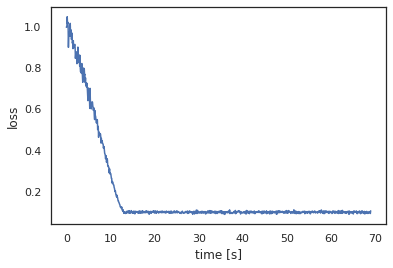

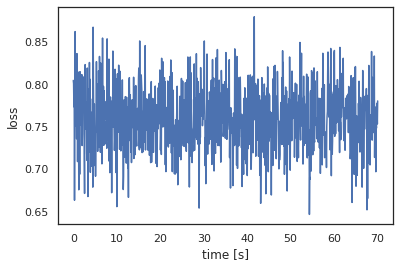

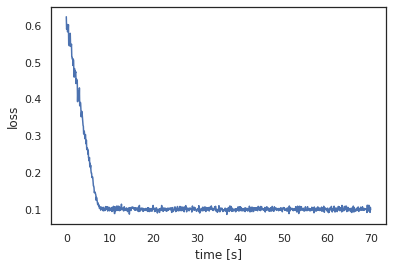

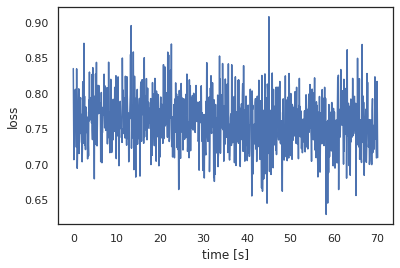

In [18]:
flips, (a_R, loss) = training_angle_alignment_GD_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [19]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([ 0.00000000e+00,  8.66233473e-04, -2.01629764e+00])>],
 0.09926133581335697)

In [20]:
angles_predicted_new = updateGD_alignment(flips, ap, a_R)

In [21]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.10085535846889089
Geodesic distance:  0.1009523838180267  rad ( 5.784145524557717  degrees)
Quaternion distance:  1.0288792967810418


(0.10085535846889089, 0.1009523838180267, 1.0288792967810418)

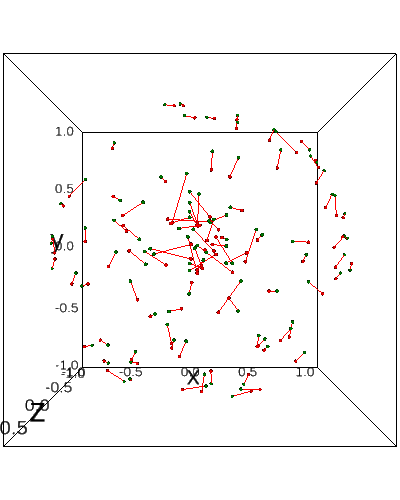

In [22]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [23]:
filename = f"figures/{PROTEIN}_after_alignment_var0.5GD"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

---

# Angle Recovery - Variance 0.8

## dP/dQ plot

In [13]:
def d_p(in1, in2):
    dist = d_q(in1, in2)
    norm_distr = tf.random.normal(shape=dist.shape, mean=dist, stddev=0.8, dtype=tf.float64)
    return norm_distr  

In [14]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=5000))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

dP_values = d_p(q1_true, q2_true)
dQ_values = d_q(q1_true, q2_true)

<Figure size 432x288 with 0 Axes>

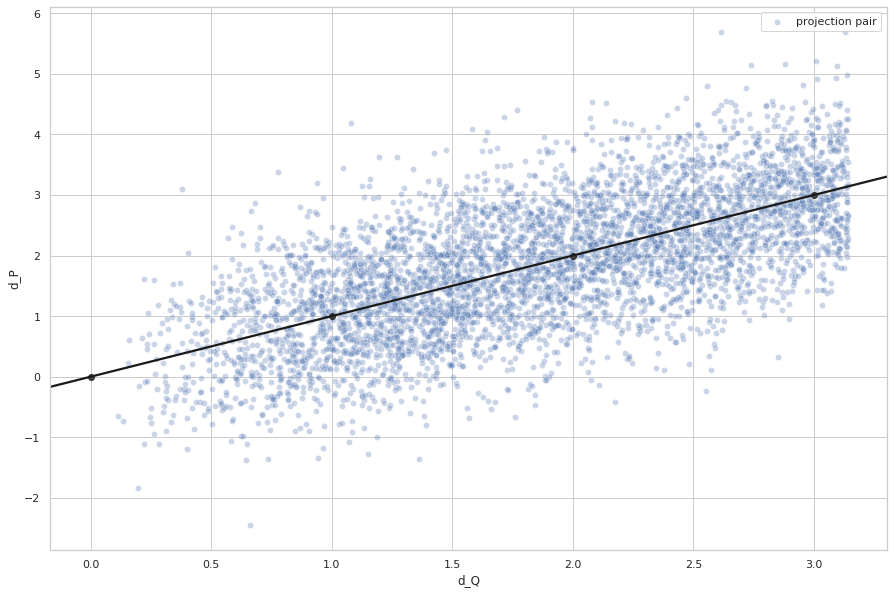

In [15]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

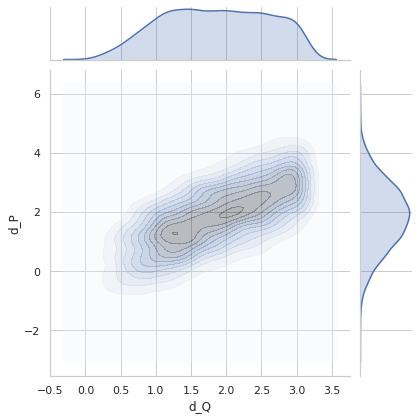

In [16]:
plot_dP_dQ_density(dP_values, dQ_values)

## Angle Recovery

In [17]:
# Try smaller variance until it is possible to converge

step 15000/150000 (1377s): loss = 7.84e-01
step 30000/150000 (2800s): loss = 6.97e-01
step 45000/150000 (4231s): loss = 6.67e-01
step 60000/150000 (5712s): loss = 6.87e-01
step 75000/150000 (7162s): loss = 7.59e-01
step 90000/150000 (8665s): loss = 6.65e-01
step 105000/150000 (10180s): loss = 7.26e-01
step 120000/150000 (11723s): loss = 6.59e-01
step 135000/150000 (13170s): loss = 7.20e-01
step 150000/150000 (14638s): loss = 6.32e-01


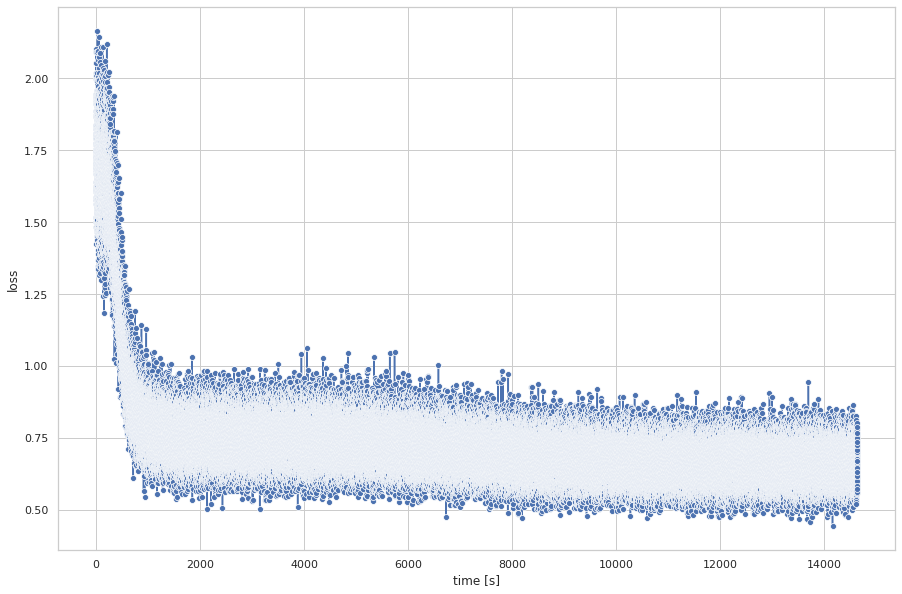

In [18]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=range(NUM_PROJECTIONS), 
                     angles_predicted=angles_predicted, 
                     est_dist_input=angles_true, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [23]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_var0.8.npy", ang_save)

In [24]:
ap = np.load("data/predicted_angles_var0.8.npy")

In [25]:
plot_euclidean_space(ap)

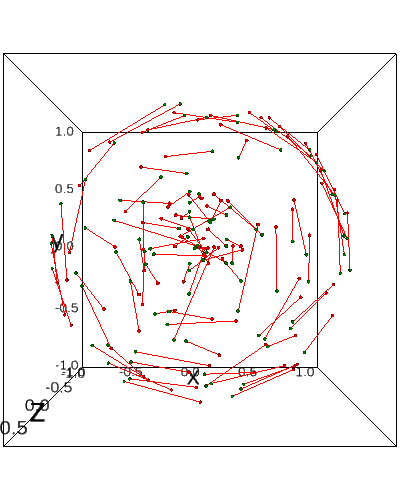

In [26]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [27]:
filename = f"figures/{PROTEIN}_before_alignment_var0.8"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

### Angle Alignment

In [28]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, training_angle_alignment_GD_flips, updateR_alignment, updateGD_alignment

#### Flip 2nd and 3rd angle

#### Quaternion Alignment

In [29]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.29311857540805325
Geodesic distance:  0.29482953242402793  rad ( 16.89248788371226  degrees)
Quaternion distance:  0.4303240739610892


(0.29311857540805325, 0.29482953242402793, 0.4303240739610892)

FLIPPING: (1, 1, 1)
step 100/1000 (6s): loss = 1.65e-01
step 200/1000 (13s): loss = 1.66e-01
step 300/1000 (20s): loss = 1.76e-01
step 400/1000 (26s): loss = 1.72e-01
step 500/1000 (33s): loss = 1.68e-01
step 600/1000 (40s): loss = 1.68e-01
step 700/1000 (46s): loss = 1.65e-01
step 800/1000 (53s): loss = 1.68e-01
step 900/1000 (59s): loss = 1.76e-01
step 1000/1000 (66s): loss = 1.75e-01
Rotation: [0.17098438 0.01317988 0.22689199];  Loss: 0.17521755508496734
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 1.53e+00
step 200/1000 (13s): loss = 1.54e+00
step 300/1000 (20s): loss = 1.63e+00
step 400/1000 (27s): loss = 1.54e+00
step 500/1000 (34s): loss = 1.57e+00
step 600/1000 (40s): loss = 1.62e+00
step 700/1000 (47s): loss = 1.54e+00
step 800/1000 (54s): loss = 1.51e+00
step 900/1000 (60s): loss = 1.43e+00
step 1000/1000 (67s): loss = 1.53e+00
Rotation: [-1.16161379 -0.00471375 -1.16927731];  Loss: 1.5271332334188548
FLIPPING: (1, -1, 1)
step 100/1000 (7s): loss = 1.29e+00
step 200/1000 

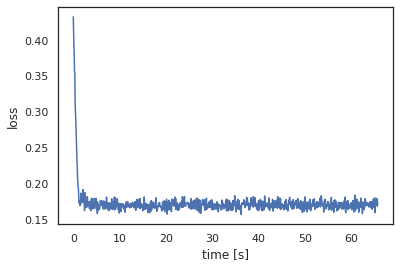

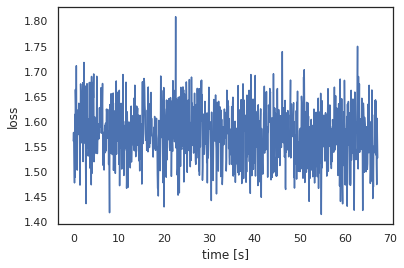

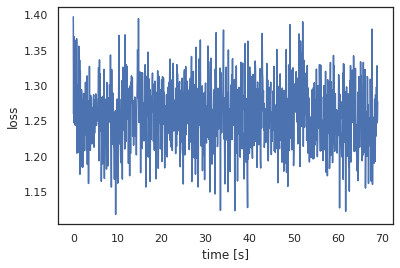

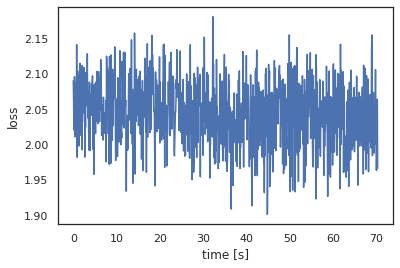

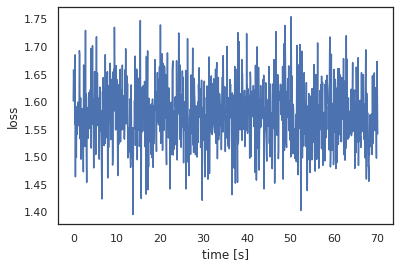

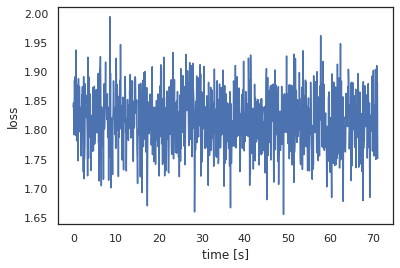

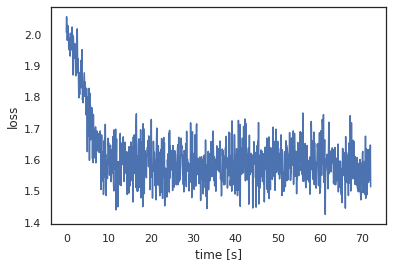

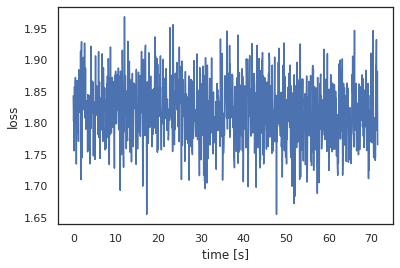

In [30]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [31]:
flips, a_R, loss

((1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([0.17098438, 0.01317988, 0.22689199])>],
 0.17521755508496734)

In [32]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [33]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.12973866189875452
Geodesic distance:  0.12994516828095914  rad ( 7.445309710616214  degrees)
Quaternion distance:  0.17043514391360612


(0.12973866189875452, 0.12994516828095914, 0.17043514391360612)

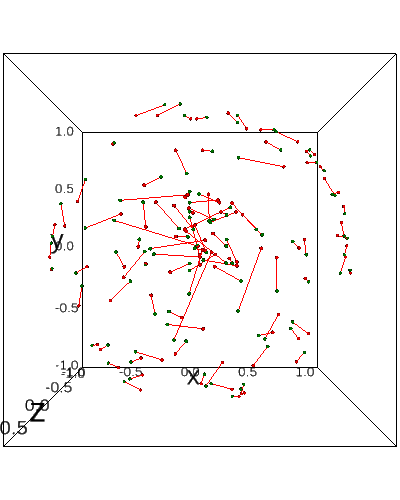

In [34]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [35]:
filename = f"figures/{PROTEIN}_after_alignment_var0.8"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

#### Geodesic Alignment

In [36]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.29311857540805325
Geodesic distance:  0.29482953242402793  rad ( 16.89248788371226  degrees)
Quaternion distance:  0.4303240739610892


(0.29311857540805325, 0.29482953242402793, 0.4303240739610892)

FLIPPING: (1, 1, 1)
step 100/1000 (7s): loss = 1.19e-01
step 200/1000 (14s): loss = 1.23e-01
step 300/1000 (21s): loss = 1.24e-01
step 400/1000 (28s): loss = 1.19e-01
step 500/1000 (34s): loss = 1.17e-01
step 600/1000 (41s): loss = 1.24e-01
step 700/1000 (48s): loss = 1.19e-01
step 800/1000 (55s): loss = 1.21e-01
step 900/1000 (61s): loss = 1.15e-01
step 1000/1000 (68s): loss = 1.20e-01
Rotation: [ 0.         -0.00363437  0.46765975];  Loss: 0.11989981750330093
FLIPPING: (1, 1, -1)
step 100/1000 (7s): loss = 7.55e-01
step 200/1000 (14s): loss = 7.75e-01
step 300/1000 (21s): loss = 7.88e-01
step 400/1000 (28s): loss = 8.17e-01
step 500/1000 (35s): loss = 7.15e-01
step 600/1000 (41s): loss = 7.93e-01
step 700/1000 (48s): loss = 8.09e-01
step 800/1000 (55s): loss = 7.54e-01
step 900/1000 (62s): loss = 7.83e-01
step 1000/1000 (69s): loss = 7.04e-01
Rotation: [ 0.         -0.06687495 -1.18097407];  Loss: 0.7039147395012169
FLIPPING: (1, -1, 1)
step 100/1000 (7s): loss = 8.34e-01
step 200/10

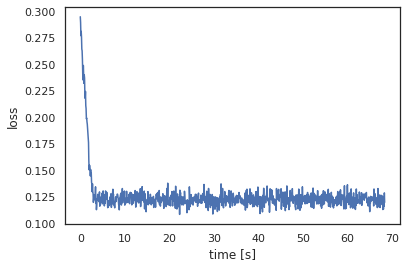

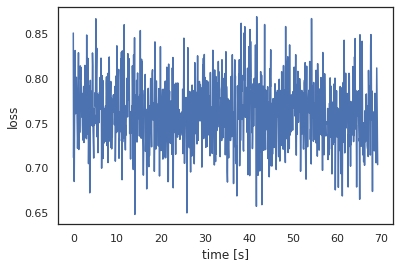

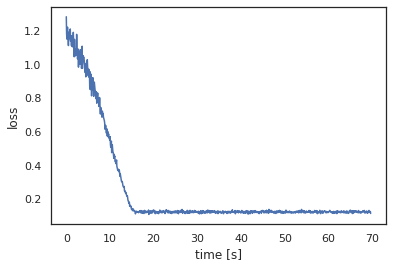

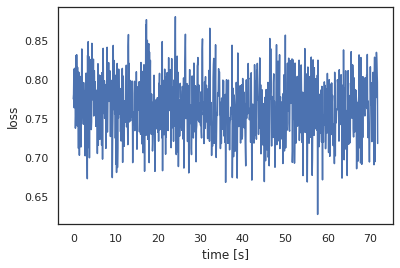

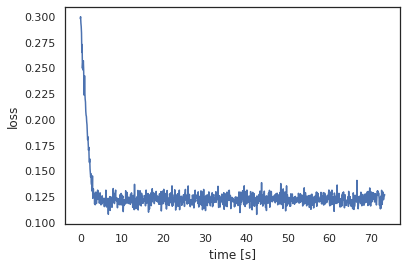

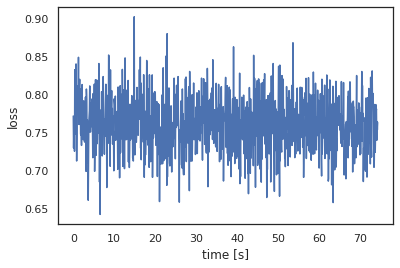

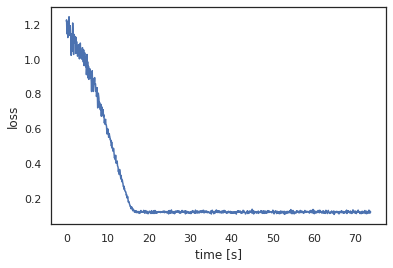

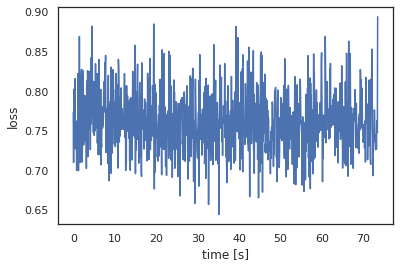

In [37]:
flips, (a_R, loss) = training_angle_alignment_GD_flips(steps=1000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [38]:
flips, a_R, loss

((1, -1, 1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([ 0.00000000e+00, -1.06538378e-03, -2.67171246e+00])>],
 0.11336497013469098)

In [39]:
angles_predicted_new = updateGD_alignment(flips, ap, a_R)

In [40]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.12214994555928617
Geodesic distance:  0.12233867215365392  rad ( 7.009489585639019  degrees)
Quaternion distance:  3.028335999895571


(0.12214994555928617, 0.12233867215365392, 3.028335999895571)

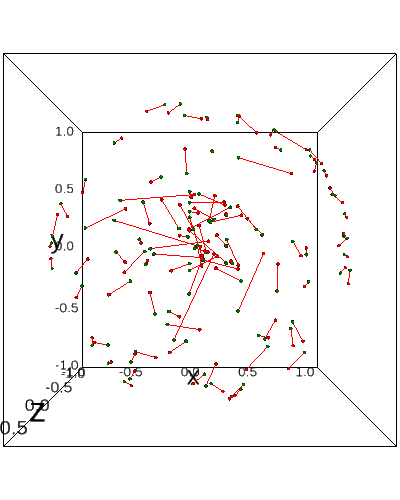

In [41]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [42]:
filename = f"figures/{PROTEIN}_after_alignment_var0.8GD"
save_space_plot(filename)

Image(filename=f"{filename}.png",width=300, height=300)

Output()

---

---